## Recurrent Neural Network

이번 장에서는 금융 시계열 분석에 대한 다양한 신경망 모델을 제시하고 금융 계량경제학의 잘 알려진 기법과 어떻게 연관되는지 예제를 제공한다. Recurrent Neural Network는 비선형 시계열 모델로 제시되고, $\text{AR}(p)$와 같은 고전적 선형 시계열 모형을 일반화한다. 이들은 금융 시계열 예측을 위한 강력한 접근법을 제공하고, 비정상성 데이터로 일반화하며, 시간에 걸쳐 고유한 Parameter를 가진다. 

In [1]:
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42) 

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)

In [2]:
START = '1960-01-01'
TICKER = '^GSPC' # S&P500 Index

data = yf.download(
    TICKER,
    start = START,
    progress = False,
    interval = '1wk'
)

In [3]:
returns = data['Close'].pct_change(1).dropna()

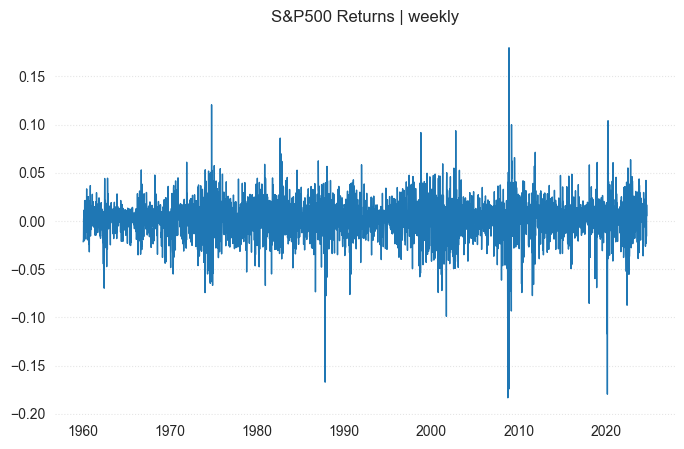

In [4]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.plot(
    returns,
    lw = 1
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('S&P500 Returns | weekly')
plt.show()

Data $\mathcal{D} =:= \{x_t, y_t\}_{t=1}^N$가 시점 $t=1, \dots, N$에서 $X$와 $Y$의 자기상관성 있는 관측치인 경우 예측 문제를 sequence prediction 문제로 나타낼 수 있다. 즉 $T$ 길이의 부분 시퀀스로 구성된 고차원 입력 행렬 $X_t$를 이용해 반응$y_{t+h}$의 비선형 예측기 $\hat{y}_{t+h}$를 구축하는 문제이다.

$$\hat{y}_{t+h} = f(X_t) \text{ where } X_t := \text{seq}_{T,t}(X) = \left(x_{t-T+1}, \dots, x_t\right)$$

한편, Vanilla RNN 모형은 다음과 같이 작성할 수 있다

$$
\begin{align*}
h_t &= \sigma(W_{ih} x_t + b_{ih} + W_{hh} h_{t-1} + b_{hh}) \\
y_t &= W_{ho} h_t + b_o
\end{align*}
$$

여기서 다음과 같이 특수한 모양의 RNN모형을 고려한다. 1개의 hidden layer($H = 1$), activation function은 없고 입력 벡터의 차원 $P = 1$인 간단한 경우의 RNN을 고려해 보자. 추가로 $W_{z}^{(1)} = \phi_z, \vert \phi_z \vert < 1, W_x^{(1)} = \phi_x, W_y = 1, b_h = 0, b_y = \mu$를 가정하자. 그러면 $f_{W^{(1)}, b^{(1)}}^{(1)}(X_t)$가 자기회귀 계수가 기하급수적으로 감쇠하는, 즉 $\phi_i = \phi_x \phi_z^{i-1}$인 $p$차 자기회귀 $\text{AR}(p)$ 모형임을 보일 수 있다.

$$
\begin{align*}
z_{t-p} &= \phi_x x_{t-p} \\
z_{t-T+2} &= \phi_z z_{t-T+1} + \phi_x x_{t-T+2} \\
\dots &= \dots \\
z_{t-1} &= \phi_z z_{t-2} + \phi_x x_{t-1} \\
\hat{x}_t &= z_{t-1}+\mu \\
\end{align*}
$$

위 조건하에서 다음이 성립한다.

$$
\begin{align*}
\hat{x}_t &= \mu + \phi_x \left( L + \phi_z L^2 + \cdots + \phi_z^{p-1}L^p\right) \\
 &= \mu + \sum_{i=1} \phi_i x_{t-i}
\end{align*}
$$

이 특수한 경우의 자기회귀 모델 $\hat{x}_t$는 안정적이고 차수는 Durbin-watson, Ljung-Box, Box-Pierce 테스트와 같은 자기상관계수 테스트를 통해 식별 가능하다. 구조를 바꿔 순환 가중치 $W_{z,i}^{(1)} = \phi_{z,i}$가 lag dependent이라면 non-activated Hidden Layer는 다음과 같아진다.

$$z_{t-i} = \phi_{z,i} z_{t-i-1} + \phi_x x_{t-i}$$

이로부터 다음을 도출한다.

$$\hat{x}_t = \mu + \phi_x \left( L + \phi_{z,1}L^2 + \cdots + \prod_{i=1}^{p-1} \phi_{z,i}L^p\right)\left[x_t\right]$$

따라서 이 $\text{AR}(p)$ 모형의 가중치는 $\phi_j = \phi_x \prod_{i=1}^{j-1} \phi_{z,i}$이며, 이는 기본 RNN, 즉 가중치가 기하급수적으로 감소하는 경우에 제한된 경우보다 더 유연한 자기상관 구조를 표현할 수 있다. 무한 수의 Time lag를 가지고 편향이 없는 선형 RNN은 지수 평활화 기법에 상응한다. 즉 $W_z = 1 - \alpha, W_x = \alpha, W_y = 1$일 때의 $z_t = \alpha x_t + (1 - \alpha)z_{t-1}$에 상응한다. 선형 RNN을 $\text{AR}(p)$에서 $\text{VAR}(p)$로 일반화하는 것은 매우 쉬우며, 다음과 같이 표현할 수 있다.

$$\hat{x}_t = \boldsymbol{\mu} + \sum_{j=1}^p \phi_j x_{t-j}$$ 

$$\phi_j := W^{(2)}\left( W_z^{(1)}\right)^{j-1} W_x^{(1)}$$

$$\boldsymbol{\mu} := W^{(2)}\sum_{j=1}^{p} \left( W_z^{(1)}\right)^{j-1} b^{(1)} + b^{(2)}$$

### 1. RNN Memory : Partial Auto Covariance

일반적으로 비선형 활성 함수를 가지고 있는 RNN을 고전적 모델로 묘사하는 것은 더욱 힘들다. 그러나 PACF는 여기서 추가적인 통찰력을 제공한다. 우선 $\text{RNN}(1)$프로세스를 고려해 보자. time lag가 1인 PACF는 다음과 같다.

$$\tilde{\gamma}_1 = \mathbb{E} \left[ 
y_t - \mu, y_{t-1} - \mu
\right] = \mathbb{E} \left[ 
\hat{y}_t + \epsilon_t - \mu, y_{t-1} - \mu
\right]$$

단순화를 위해 단일 순환 가중치 $\phi$를 가진 $\text{RNN}(1)$모델을 사용하면 다음과 같다.

$$\hat{y}_t = \sigma \left( \phi y_{t-1}\right)$$

위 식에서 다음을 구할 수 있다

$$\tilde{\gamma}_1 = \mathbb{E} \left[ 
\sigma(\phi y_{t-1}) + \epsilon_t - \mu, y_{t-1} - \mu
\right] = \mathbb{E} \left[ y_{t-1} \sigma(\phi y_{t-1})\right]$$

여기서 표현식의 두 번째 부분에서 $\mu = 0$으로 가정했다. $\sigma := Id$로 놓으면 다음과 같이 $\text{AR}(1)$ 공분산을 복구할 수 있다

$$\tilde{\gamma}_1 = \phi \mathbb{E}[y_{t-1}^2] = \phi \mathbb{V} [y_{t-1}]$$

lag-2Auto Covariance로 계속하면 다음을 얻는다

$$\tilde{\gamma}_2 = \mathbb{E}\left[
y_t - P(y_t | y_{t-1}), y_{t-2} - P(y_{t-2} | y_{t-1}) 
\right]$$

그리고 $P(y_t | y_{t-1})$는 다음과 같이 $\text{RNN}(1)$에 의해 근사된다.

$$\hat{y}_t = \sigma(\phi y_{t-1})$$

위 식에 $y_t = \hat{y}_t + \epsilon_t$를 대입하면

$$\tilde{\gamma}_2 = \mathbb{E} \left[
\epsilon_t, y_{t-2} - P(y_{t-2} | y_{t-1})
\right]$$

을 얻을 수 있다. $P(y_{t-2} | y_{t-1})$를 후방 $\text{RNN}(1)$로 근사하면 다음과 같다.

$$\hat{y}_{t-2} = \sigma \left( \phi(\hat{y}_{t-1} + \epsilon_{t-1})\right)$$

위 식에서 $\hat{y}_{t-2}$가 $\epsilon_{t-1}$에 의존하며, $\epsilon_t$에는 의존하지 않는 것을 알 수 있다. 따라서 $y_{t-2} - P(y_{t-2} | y_{t-1})$는 $\left\{ \epsilon_{t-1}, \epsilon_{t-2}, \dots \right\}$에 의존한다. 결과적으로 $\tilde{\gamma}_2 = 0$을 얻는다.

반대로 $\text{RNN}(2)$ Process의 lag-2 Partial Auto Covariance를 고려하자.

$$\hat{y}_{t-2} = \sigma \left( \phi \sigma (\phi(\hat{y}_t + \epsilon_t) + \epsilon_{t-1})\right)$$

이는 $\epsilon_t$에 의존하며, 따라서 lag-2 Partial Auto Covariance는 0이 아니다. Partial Auto Correlation $\tilde{\tau}_s = 0, s>p$이고, 결과적으로 $\text{AR}(p)$ Process와 같이 $\text{RNN}(p)$에 대한 Partial Auto Correlation Function(PACF)는 lag $p$에서 cut-off된다. 여기서 PACF는 시간에 대해 독립적이라고 가정한다. 이와 같은 속성은 추정된 PACF로부터 $\text{RNN}$ 모형의 차수를 식별하는데 사용될 수 있음을 의미한다.

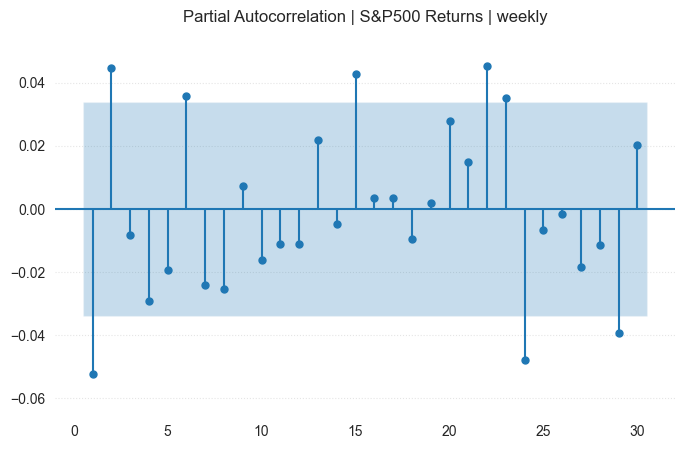

In [5]:
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(figsize = (8, 5))
plot_pacf(returns, ax = ax, lags = range(1, 31),  auto_ylims = True)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Partial Autocorrelation | S&P500 Returns | weekly')
plt.show()

### 2. Stability

후에 제시되는 $\text{AR}(p)$ 모델에 대한 안정성 제약을 다음 $\text{RNN}(1)$ 모형을 고려함으로써 $\text{RNN}$으로 일반화한다.

$$y_t = \Phi^{-1}(L)[\epsilon_t] = (1 - \sigma(W_z L + b))^{-1}[\epsilon_t]$$

여기서 일반성을 잃지 않고 $W_y = 1$이고, $b_y = 0$으로 설정하고 표기상의 편의를 위해 위 첨자를 제거한다. 이것을 무한차원 비선형 이동평균 모델로 표현하면 다음을 얻는다

$$y_t = \frac{1}{1 - \sigma(W_z L + b)}[\epsilon_t] = \sum_{j=0}^\infty \sigma^j (W_z L + b)[\epsilon_t]$$

### 3. Stationarity

위에서 고려한 선형 일변량 $\text{RNN}(p)$는 다음의 동반 행렬을 가진다

$$C := \begin{pmatrix} 
0 & 1 & 0 & \cdots & 0 \\ 
0 & 0 & 1 & 0 & \vdots \\
\vdots & \ddots & \ddots & \ddots & \vdots \\
0 & 0 & 0 & 0 & 1 \\
\phi^{-p} & -\phi^{-p+1} & \cdots & -\phi^{-2} & -\phi^{-1}
\end{pmatrix}$$

그리고 $\phi \neq 0$일 때 모형은 비정상성을 갖는다. 이는 선형 $\text{RNN}$의 경우이므로 선형 활성 함수의 선택을 배제할 수 있다. 따라서 모델이 정상성을 가지려면 어떤 비선형 활성화 함수가 필요한 것으로 보인다. 그러나 Cayley-Hamilton을 이용해 정상성을 증명할 수는 없다.

#### Half Life

$\text{RNN}$의 출력이 $\mathbb{R}^d$에 있다고 가정하자. lag의 반감기는 $\tilde{\sigma}(x) := \sigma(W_z x + b)$의 자체의 함수 구성 중 정규화된 $j$번째 출력에 대해 다음이 성립하는 가장 작은 수 $k$이다.

$$r_j^{(k)} = \frac{
\left( W_y \tilde{\sigma}\circ_1 \tilde{\sigma}\circ_2 \cdots \circ_2_{k-1} \tilde{\sigma}(\boldsymbol{1}) + b_y\right)
}{
\left( W_y \tilde{\sigma}(\boldsymbol{1}) + b_y\right)_j
} \leq 0.5, k \geq 2, \forall j \in \left\{ 1, \dots, d\right\}$$

출력이 정규화됐으므로 lag-1의 단위 충격반응함수는 각 $j$에 대해 비율 $r_j^{(1)} = 1$임을 보장한다. 이 수정된 정의는 활성화 함수와 $\text{AR}(p)$ 모델에 존재하지 않는 준어파인 변환의 효과를 설명하고자 존재한다. 일반적으로 반감기가 유한하다는 보장은 없지만, 반감기를 발견할 수 있는 paramter의 값들을 찾을 수 있다. 예를 들어, 단순성을 위해 일변량 $\text{RNN}$이 $\hat{x}_t = z_{t-1}$에 의해 주어지고 다음과 같다고 가정하자.

$$z_t = \sigma(z_{t-1} + x_t)$$

그러면 lag-1 충격은 $\hat{x}_t = \tilde{\sigma}(\boldsymbol{1}) = \sigma(0 + 1)$이고, lag-2 충격은 $\hat{x}_t = \sigma(\sigma(1) + 1) = \tilde{\sigma} \circ \tilde{\sigma}(1)$이 되는 방식으로 계산된다.

In [6]:
import torch.nn as nn
import torch.optim as optim

class RecurrentNeuralNetwork(nn.Module):
    def __init__(
            self, 
            input_size : int, 
            hidden_size : int, 
            output_size : int, 
            num_layers : int = 2 
        ) -> None :
        super(RecurrentNeuralNetwork, self).__init__()
        self.rnn = nn.RNN(
            input_size, 
            hidden_size, 
            num_layers, 
            batch_first = True
        )
        self.fc = nn.Linear(
            hidden_size, 
            output_size
        )
        
    def forward(self, x):
        out, hidden = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

In [7]:
X = pd.concat(
    [returns.shift(1), returns.shift(2)], axis = 1
).dropna()
y = returns.iloc[2:].copy('deep')

X.columns = ['t-1','t-2']
y.name = 'returns'

In [8]:
X.head()

,t-1,t-2
Date,,
1960-01-22,-0.020377,-0.021612
1960-01-29,-0.018878,-0.020377
1960-02-05,0.002494,-0.018878
1960-02-12,-0.019371,0.002494
1960-02-19,0.011236,-0.019371


In [9]:
y.head()

Date
1960-01-22   -0.018878
1960-01-29    0.002494
1960-02-05   -0.019371
1960-02-12    0.011236
1960-02-19    0.002330
Name: returns, dtype: float64

In [10]:
# train test data split
X_train, X_test, y_train, y_test = X.loc[:'2019'], X.loc['2020':], y.loc[:'2019'], y.loc['2020':]

In [11]:
input_size = 2 # input size (number of features), RNN(p)
hidden_size = 2 # number of hidden nodes
output_size = 1 # output size
num_layers = 1 # number of hidden layers
learning_rate = 0.001
num_epochs = 1
batch_size = 2

# Feature Preprocessing
X_train_values = X_train.values.reshape(-1, 1, input_size)
X_test_values = X_test.values.reshape(-1, 1, input_size)

y_train_values = y_train.values.reshape(-1, 1)
y_test_values = y_test.values.reshape(-1, 1)

X_train_tensor = torch.tensor(X_train_values, dtype = torch.float32)
X_test_tensor = torch.tensor(X_test_values, dtype = torch.float32)
y_train_tensor = torch.tensor(y_train_values, dtype = torch.float32)
y_test_tensor = torch.tensor(y_test_values, dtype = torch.float32)

In [12]:
rnn = RecurrentNeuralNetwork(
    input_size, 
    hidden_size, 
    output_size,
    num_layers
)

criterion = nn.MSELoss()
optimizer = optim.Adam(
    rnn.parameters(), 
    lr = learning_rate
)

In [13]:
dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle = False)

In [14]:
for epoch in range(num_epochs):
    rnn.train()
    epoch_loss = 0.0
    for batch_X, batch_y in dataloader:
        optimizer.zero_grad()
        outputs = rnn(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch_X.size(0)
    epoch_loss /= len(dataloader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.6f}')

Epoch [1/1], Loss: 0.036407


In [15]:
rnn.eval()
with torch.no_grad():
    predicted_full = rnn(X_test_tensor)
    predicted_full = predicted_full.squeeze().numpy()
    y_test_np = y_test_tensor.squeeze().numpy()

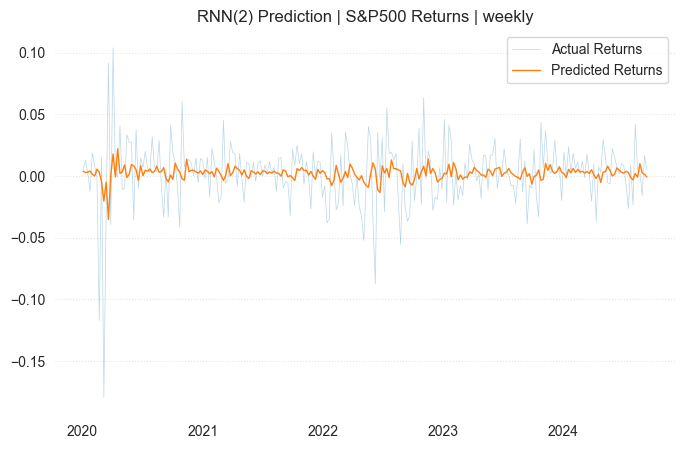

In [16]:
fig, ax = plt.subplots(figsize = (8, 5))
plt.plot(y_test.index, y_test_np, label = 'Actual Returns', lw = 0.5, alpha = 0.3)
plt.plot(y_test.index, predicted_full, label = 'Predicted Returns', lw = 1)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.legend()
plt.title('RNN(2) Prediction | S&P500 Returns | weekly')
plt.show()

### 4. Generalized Recurrent Neural Network

앞에서 설명한 것과 같은 고전적인 $\text{RNN}$은 오차를 등분산성으로 취급한다. 즉, 오차는 i.i.d이다. 손실 함수를 잔차 벡터 제곱의 Mahalanobis 길이로 수정해 $\text{RNN}$을 이분산성 모형으로 일반화할 수 있다는 것을 간단히 언급한다. 이러한 접근법은 Generalized Recurrent Neural Network라고 불린다. 여기서 계량경제학에서의 Machine Learning 분야는 초기임으로 불완전하며, 이러한 방법론이 이론적인 관점에서는 호소력이 있지만 실제로는 아직 입증되지 않았다는 주의 사항을 간략히 언급한다.

가장 간단한 형태로 우리는 데이터 $\mathcal{D}_t$를 사용해 가중 최소 제곱 최소화 문제를 해결한다

$$
\begin{align*}
\min_{W,b} ~ & ~ f(W, b) + \lambda \phi(W,b) \\
\mathcal{L}_{\Sigma} (Y, \hat{Y}) & := (Y - \hat{Y})^T \Sigma^{-1} (Y - \hat{Y}) \\
\Sigma_{tt} &= \sigma_t^2 \\
\Sigma_{tt^\prime} &= \rho_{tt^\prime} \sigma_t \sigma_t^\prime \\
f(W,b) &= \frac{1}{T} \sum_{t=1}^T \mathcal{L}_{\Sigma}(y_t, \hat{y}_t)
\end{align*}
$$

여기서 $\Sigma := \mathbb{E} \left[ \epsilon \epsilon^T | \mathcal{X}_t \right]$는 잔여 오차의 조건부 공분산 행렬이고, $\phi(W,b)$는 규제화 패널티 항이다. 여기서 조건부 공분산 행렬은 추정되어야만 한다. 이는 벡터의 전치 행렬을 나타내는 $()^T$와 이분산성 오차 하에서 적합화된 모델 파라미터를 나타내는 $()^\prime$ 표기법을 사용해 다음과 같이 수행한다. 우선, 각 $t = 1, 2, \dots, T$에 대해 표준 손실 함수를 사용해 가중치 $\hat{W}_t$와 편향 $\hat{b}_t$를 찾아 Training Set에 대한 잔여 오차 $\boldsymbol{\epsilon}_t \in \mathbb{R}^N$을 추정한다. 여기서 오차는 다음과 같다.

$$\boldsymbol{\epsilon}_t = \boldsymbol{y}_t - F_{\hat{W}_t, \hat{b}_t}(\mathcal{X}_t)$$

Sample Conditional Covariance Matrix $\hat{\Sigma}$는 다음과 같이 추정된다.

$$\hat{\Sigma} = \frac{1}{T - 1}\sum_{i=1}^T \boldsymbol{\epsilon}_t \boldsymbol{\epsilon}_t ^T$$

가중 최소제곱 최소화 문제를 수행해 적합화된 이분산성 신경망 모형을 추정한다. 이 때의 더 정교화된 오차는 다음과 같다.

$$\boldsymbol{\epsilon}_t^\prime = \boldsymbol{y}_t - F_{\hat{W}_t^\prime, \hat{b}_t^\prime} (\mathcal{X}_t)$$

적합화된 $\text{GRNN} F_{\hat{W}_t^\prime, \hat{b}_t^\prime}$은 다음에 더 이상의 수정 없이 예측에 사용될 수 있다. Sample Covariance Matrix의 효과는 오차의 분산과 오차 상관관계를 기반으로 Training Set의 관찰 중요도를 조정하는 것이다. 이와 같은 접근법은 $\text{GARCH}$ 모델이 $\text{AR}$ 모델을 확장하는 방법과 유사하게 $\text{RNN}$에 적용된 것으로 생각할 수 있다. 물론 $\text{GARCH}$모형은 오차 분포를 모수적으로 다루고 조건부 변동성을 예측하고자 순환 관계를 추정한다. 대조적으로 $\text{GRNN}$은 경험적 오차 분포에 의존하며, 조건부 변동성을 예측하지 않는다. 그러나 시계열 교차 검증을 사용해 별도의 회귀식이 경험적 조건부 변동성 $\Sigma$의 대각에 걸쳐 수행된다.

In [17]:
class GRNNCell(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRNNCell, self).__init__()
        self.hidden_size = hidden_size
        self.rnn_cell = nn.RNNCell(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, h_prev):
        h_next = torch.tanh(self.rnn_cell(x, h_prev))
        output = self.fc(h_next)
        return output, h_next

class GRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(GRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.cells = nn.ModuleList([GRNNCell(input_size if i == 0 else hidden_size, hidden_size, output_size) for i in range(num_layers)])
    
    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        h = [torch.zeros(batch_size, self.hidden_size, device=x.device) for _ in range(self.num_layers)]
        outputs = []
        for t in range(seq_len):
            x_t = x[:, t, :]
            for i, cell in enumerate(self.cells):
                output, h[i] = cell(x_t, h[i])
                x_t = output  # Pass the output to the next layer if there are multiple layers
            outputs.append(output.unsqueeze(1))
        
        return torch.cat(outputs, dim=1)

In [18]:
grnn = GRNN(
    input_size, 
    hidden_size, 
    output_size,
    num_layers
)

criterion = nn.MSELoss()
optimizer = optim.Adam(
    grnn.parameters(), 
    lr = learning_rate
)

In [22]:
num_epochs = 1
for epoch in range(num_epochs):
    grnn.train()
    optimizer.zero_grad()

    outputs = grnn(X_train_tensor)

    outputs = torch.mean(outputs[:, -1, :], dim = 1, keepdim = True)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')

Epoch [1/1], Loss: 0.000471


In [26]:
grnn.eval()
with torch.no_grad():
    predicted_grnn = grnn(X_test_tensor)
    predicted_grnn = predicted_grnn[:, -1, :].mean(dim=1).squeeze().numpy()
    y_test_np = y_test_tensor.squeeze().numpy()

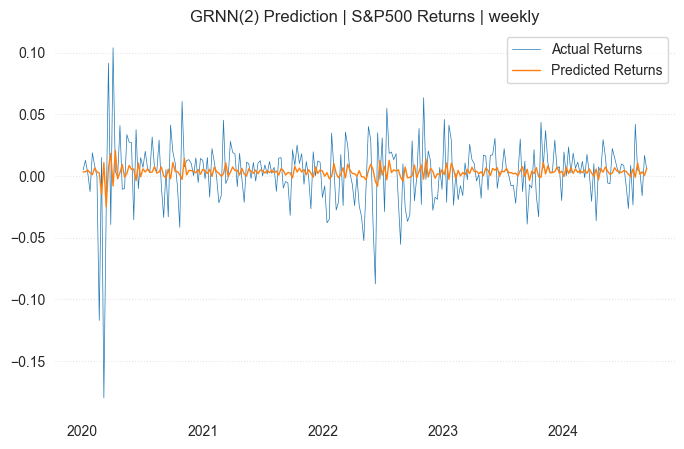

In [27]:
fig, ax = plt.subplots(figsize = (8, 5))
plt.plot(y_test.index, y_test_np, label = 'Actual Returns', lw = 0.5)
plt.plot(y_test.index, predicted_grnn, label = 'Predicted Returns', lw = 1)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.legend()
plt.title(r'GRNN(2) Prediction | S&P500 Returns | weekly')
plt.show()